# Drug Side Effects and Medical Condition Analysis

## Exploratory Data Analysis & Model Development

**Author:** Sri Nithya S 
**Objective:** Predict medical conditions from drug side effects using NLP and Machine Learning

## 1. Setup & Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [2]:
# Load dataset
df = pd.read_csv('drugs_side_effects_drugs_com.csv')
print("✅ Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(df.head())

✅ Dataset loaded successfully!
Dataset shape: (2931, 17)
        drug_name medical_condition  \
0     doxycycline              Acne   
1  spironolactone              Acne   
2     minocycline              Acne   
3        Accutane              Acne   
4     clindamycin              Acne   

                                        side_effects         generic_name  \
0  (hives, difficult breathing, swelling in your ...          doxycycline   
1  hives ; difficulty breathing; swelling of your...       spironolactone   
2  skin rash, fever, swollen glands, flu-like sym...          minocycline   
3  problems with your vision or hearing; muscle o...  isotretinoin (oral)   
4  hives ; difficult breathing; swelling of your ...  clindamycin topical   

                                        drug_classes  \
0         Miscellaneous antimalarials, Tetracyclines   
1  Aldosterone receptor antagonists, Potassium-sp...   
2                                      Tetracyclines   
3  Miscellaneous anti

## 2. Exploratory Data Analysis

### 2.1 Load Dataset

In [3]:
# Display dataset info
df.info()
df.isnull().mean().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2931 entries, 0 to 2930
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   drug_name                      2931 non-null   object 
 1   medical_condition              2931 non-null   object 
 2   side_effects                   2807 non-null   object 
 3   generic_name                   2888 non-null   object 
 4   drug_classes                   2849 non-null   object 
 5   brand_names                    1718 non-null   object 
 6   activity                       2931 non-null   object 
 7   rx_otc                         2930 non-null   object 
 8   pregnancy_category             2702 non-null   object 
 9   csa                            2931 non-null   object 
 10  alcohol                        1377 non-null   object 
 11  related_drugs                  1462 non-null   object 
 12  medical_condition_description  2931 non-null   o

alcohol                          0.530194
related_drugs                    0.501194
no_of_reviews                    0.458888
rating                           0.458888
brand_names                      0.413852
pregnancy_category               0.078130
side_effects                     0.042306
drug_classes                     0.027977
generic_name                     0.014671
rx_otc                           0.000341
medical_condition_description    0.000000
drug_link                        0.000000
drug_name                        0.000000
csa                              0.000000
medical_condition                0.000000
activity                         0.000000
medical_condition_url            0.000000
dtype: float64

### 2.2 Target Variable Analysis
Unique Medical Conditions

In [4]:
df['medical_condition'].nunique()

47

Distribution

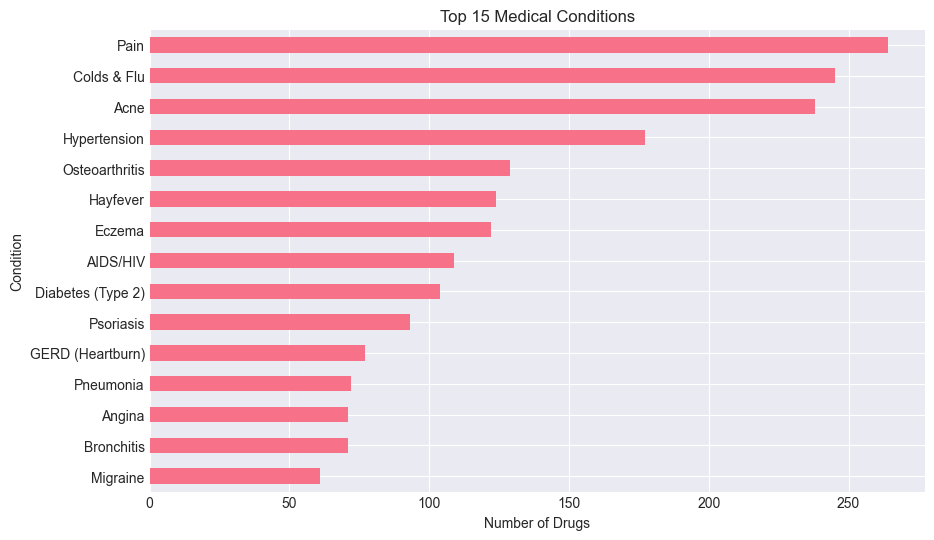

In [5]:
condition_counts = df['medical_condition'].value_counts()
condition_counts.head(15)

plt.figure(figsize=(10,6))
condition_counts.head(15).plot(kind='barh')
plt.title('Top 15 Medical Conditions')
plt.xlabel('Number of Drugs')
plt.ylabel('Condition')
plt.gca().invert_yaxis()
plt.show()

**Clinical Interpretation**

Highly imbalanced

Long-tail conditions (<50 samples)

Direct 47-class modeling is unstable

### 2.3 Rare Class Impact Analysis


In [6]:
(condition_counts < 50).sum()

25

Over 40% of conditions have fewer than 50 samples → macro-F1 collapse risk.

**Decision**: Merge rare classes into Other

## 3. Side Effect Text Analysis

### 3.1 Length Distribution

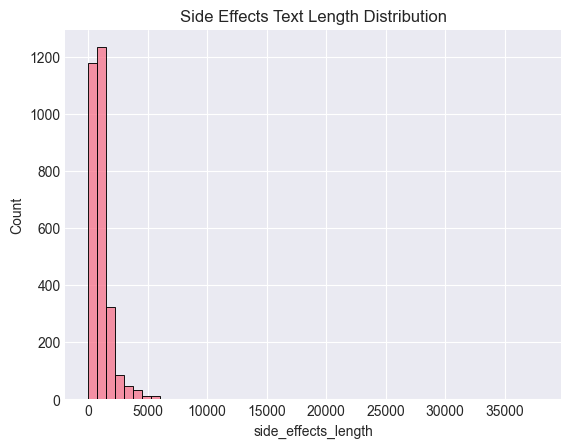

In [7]:
df['side_effects_length'] = df['side_effects'].fillna('').apply(len)
df['side_effects_length'].describe()

sns.histplot(df['side_effects_length'], bins=50)
plt.title('Side Effects Text Length Distribution')
plt.show()

### 3.2 Validate the result
#### **Step 1: Quantify outliers** 

In [ ]:
df['side_effects_length'].describe(percentiles=[0.90, 0.95, 0.99])

count     2931.000000
mean      1135.814739
std       1560.551436
min          0.000000
50%        913.000000
90%       1875.000000
95%       2622.000000
99%       4692.800000
max      37865.000000
Name: side_effects_length, dtype: float64

**Interpretation:**
99% of the dataset lives under ~5K characters

The top ~1% is 8×–10× longer than the rest

This is no longer “skew” — it’s structural imbalance.

#### **Step 2: Inspect the extreme tail (clinically)**

In [9]:
df.sort_values('side_effects_length', ascending=False)[
    ['drug_name', 'medical_condition', 'side_effects_length']
].head(5)


,drug_name,medical_condition,side_effects_length
1973,infliximab,IBD (Bowel),37865
2066,zopiclone,Insomnia,31868
601,salbutamol,Asthma,30370
1133,bamlanivimab and etesevimab,Covid 19,28491
2711,coal tar/salicylic acid,Psoriasis,26807


**Interpretation**:

These are regulatory-style monographs, not typical side-effect summaries.

So we now know:
1. Long texts ≠ “more side effects”
2. Long texts = “different document type”

#### **Step 3: Length vs Target leakage check (important)**

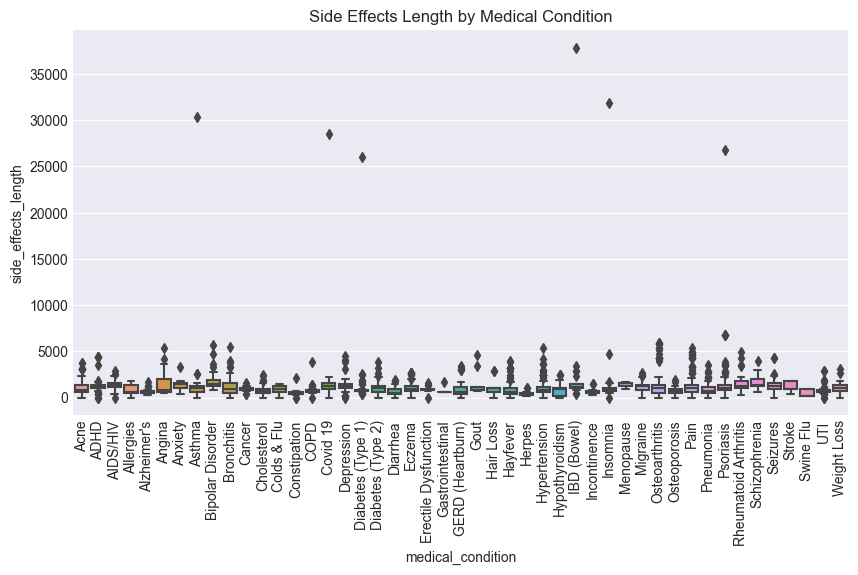

In [10]:
plt.figure(figsize=(10,5))
sns.boxplot(
    data=df,
    x='medical_condition',
    y='side_effects_length'
)
plt.xticks(rotation=90)
plt.title('Side Effects Length by Medical Condition')
plt.show()


**Interpretation**:

Text length is not uniformly distributed across labels, so:

TF-IDF may overweight these conditions

Length may act as a soft proxy for the target

## 4. Outlier and Structural Text Analysis

1. Percentile analysis reveals that **99% of side-effect descriptions are under approximately 4,700 characters**, while a small subset **exceeds 30,000** characters. **Manual inspection** confirms that these **extreme values** correspond to **regulatory-style drug monographs** rather than standard side-effect summaries. 
2. Furthermore, **boxplot analysis** shows that these long texts are **unevenly distributed across medical conditions**, introducing the risk that document length may inadvertently encode target-related information.


## 5. Ready for Preprocessing

Based on EDA-driven percentile analysis and qualitative inspection, side-effect text is truncated at the 99th percentile to reduce the influence of structurally different documents while retaining over 99% of clinically relevant information.